<a href="https://colab.research.google.com/github/NikitaGalkinV/Data-Analyst-Yandex-Practicum-/blob/main/AB_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project A/B testing

## Project Description

**Task:** evaluate the results of an A/B test. You have a dataset with user actions, the terms of reference, and several auxiliary datasets at your disposal.

- Evaluate the correctness of the test.
- Analyze test results.
- Check the intersection of the test audience with the competing test;
- Check the coincidence of the test and marketing events, other problems of the time limits of the test.

**Plan:**

- Load data, fill missing data, analysis
- Correctness of the test
- EDA
- Statistical difference of fractions (z-criterion)
- Summary

## Data description

**ab_project_marketing_events.csv** - marketing events calendar for 2020;

File structure:
  
- name - name of the marketing event;
- regions - regions in which the advertising campaign will be held;
- start_dt - date when the campaign will start;
- end_dt - date when the campaign ends.

**final_ab_new_users.csv** - all users who registered in the online store from December 7 till December 21, 2020;

File structure:

- user_id - user ID;
- first_date - date of registration;
- region - region of the user;
- device - device from which the registration took place.

**final_ab_events.csv** - all events of new users in the period from December 7, 2020 to January 4, 2021;

File structure:
- user_id - user ID;
- event_dt - date and time of the event;
- event_name - type of event;
- details - additional data about the event. For example, for purchases, purchase, this field stores the cost of purchase in dollars.

**final_ab_participants.csv** - table of test participants.

Structure of the file:
- user_id - user ID;
- ab_test - test name;
- group - group of user.

## Data preprocessing

### Importing libraries and datasets

In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from scipy import stats as st
import numpy as np
import plotly.io as pio
pio.renderers.default = 'png'
from scipy.stats import norm
!pip install Kaleido
!pip install -U kaleido

In [ ]:
marketing_events = pd.read_csv("/Users/nikitagalkin/Downloads/ab_project_marketing_events.csv")
new_users = pd.read_csv("/Users/nikitagalkin/Downloads/final_ab_new_users.csv")
events = pd.read_csv("/Users/nikitagalkin/Downloads/final_ab_events.csv")
participants = pd.read_csv("/Users/nikitagalkin/Downloads/final_ab_participants.csv")


### Preprocessing gaps, changing data types, removing duplicates

In [ ]:
def info(df):
    display(df.head())
    print("–––––––––––––––––––––––––––––––––––––––––––––––––")
    display(df.info())
    print("–––––––––––––––––––––––––––––––––––––––––––––––––")
    display(df.describe(include='all'))

#### Marketing Events Calendar (2020)

In [ ]:
info(marketing_events)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


–––––––––––––––––––––––––––––––––––––––––––––––––
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

–––––––––––––––––––––––––––––––––––––––––––––––––


,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-12-25,2021-01-03
freq,1,4,1,1


In [ ]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

print('Duplicates in marketing_events:' ,marketing_events.duplicated().sum())
print()

display(marketing_events['name'])


Duplicates in marketing_events: 0



0             Christmas&New Year Promo
1         St. Valentine's Day Giveaway
2               St. Patric's Day Promo
3                         Easter Promo
4                    4th of July Promo
5            Black Friday Ads Campaign
6               Chinese New Year Promo
7     Labor day (May 1st) Ads Campaign
8      International Women's Day Promo
9      Victory Day CIS (May 9th) Event
10           CIS New Year Gift Lottery
11       Dragon Boat Festival Giveaway
12             Single's Day Gift Promo
13               Chinese Moon Festival
Name: name, dtype: object

####  All users registered in the online store from 7 to 21 December 2020

In [ ]:
info(new_users)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


–––––––––––––––––––––––––––––––––––––––––––––––––
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

–––––––––––––––––––––––––––––––––––––––––––––––––


,user_id,first_date,region,device
count,61733,61733,61733,61733
unique,61733,17,4,4
top,D72A72121175D8BE,2020-12-21,EU,Android
freq,1,6290,46270,27520


In [ ]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

print('Duplicates in new_users:' ,new_users.duplicated().sum())
print()

print('Regions:', new_users['region'].unique())


Duplicates in new_users: 0

Regions: ['EU' 'N.America' 'APAC' 'CIS']


#### All new user events between December 7, 2020 and January 4, 2021

In [ ]:
info(events)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


–––––––––––––––––––––––––––––––––––––––––––––––––
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

–––––––––––––––––––––––––––––––––––––––––––––––––


,user_id,event_dt,event_name,details
count,440317,440317,440317,62740.000000
unique,58703,267268,4,NaN
top,A3917F81482141F2,2020-12-23 02:37:24,login,NaN
freq,36,10,189552,NaN
mean,NaN,NaN,NaN,23.877631
std,NaN,NaN,NaN,72.180465
min,NaN,NaN,NaN,4.990000
25%,NaN,NaN,NaN,4.990000
50%,NaN,NaN,NaN,4.990000
75%,NaN,NaN,NaN,9.990000


In [ ]:
events['event_dt'] = pd.to_datetime(events['event_dt'])

print('Duplicates in events:' ,events.duplicated().sum())
print()

print('Events:', events['event_name'].unique())

events.groupby('event_name').agg({'details':'count'}).reset_index()


Duplicates in events: 0

Events: ['purchase' 'product_cart' 'product_page' 'login']


,event_name,details
0,login,0
1,product_cart,0
2,product_page,0
3,purchase,62740


#### Table of test participants.

In [ ]:
info(participants)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


–––––––––––––––––––––––––––––––––––––––––––––––––
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

–––––––––––––––––––––––––––––––––––––––––––––––––


,user_id,group,ab_test
count,18268,18268,18268
unique,16666,2,2
top,0FDFDA0B2DEC2D91,A,interface_eu_test
freq,2,9655,11567


In [ ]:
print('Duplicates in participants:' ,participants.duplicated().sum())

Duplicates in participants: 0


## Correctness of the test

**Technical specification**

- Test name: recommender_system_test;
- Groups: A (control), B (new payment funnel);
- Launch date: 2020-12-07;
- Date of stopping the recruitment of new users: 2020-12-21;
- Stop date: 2021-01-04;
- Audience: 15% of new users from the EU region;
- Purpose of the test: testing the changes associated with the introduction of an improved recommender system;
- Expected number of test participants: 6000.
- Expected effect: in 14 days from the moment of registration in the system, users will show an improvement in each metric by at least 10%:
     - conversions to view product cards — product_page event
     - cart views - product_cart
     - purchases - purchases.

### Compliance of data with the requirements of the terms of reference

In [ ]:
# Test filter, leave only recommender_system_test
recommender_system_test = participants.query('ab_test== "recommender_system_test"')


In [ ]:
new_users.groupby(['region']).agg({'user_id': 'nunique'})


,user_id
region,
APAC,3153
CIS,3155
EU,46270
N.America,9155


In [ ]:
# Leave only users from the EU
new_users_eu = (
    new_users.query('region == "EU"')
)

# Merge with new_users_eu
recommender_system_test = recommender_system_test.merge(
    new_users_eu[['user_id', 'first_date', 'region']],
    on='user_id')

In [ ]:
# Display the date when the recruitment of new users was stopped without time
print('End date:', events['event_dt'].max().date())
print("Days count:", (events['event_dt'].max() - events['event_dt'].min()).days)
print()

# Проверяем соответствие дат
print('Enrollment start date:', recommender_system_test['first_date'].min().date())
print('End date for recruiting new users:', recommender_system_test['first_date'].max().date())




End date: 2020-12-30
Days count: 23

Enrollment start date: 2020-12-07
End date for recruiting new users: 2020-12-21


**Summary:**

- Date of start and end of recruitment in the AV test corresponds to
- Events were recorded only until 30.12, 5 days were not recorded.

In [ ]:
users = new_users[new_users['first_date'] <= '2020-12-21']


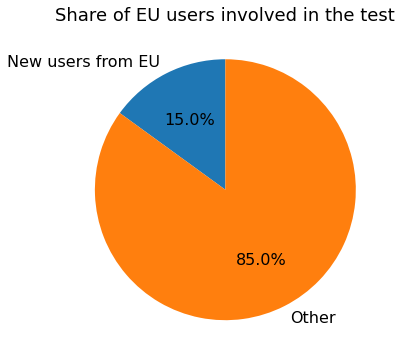

In [ ]:
prcnt = recommender_system_test['region'].value_counts()[0] / users['region'].value_counts()[0]

labels = ['New users from EU', 'Other']
sizes = [prcnt, 1 - prcnt]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 16})
ax.set_title('Share of EU users involved in the test', fontsize=18)
fig.set_size_inches(6, 6)

plt.show()

**Summary:**

- Share of users matched

In [ ]:
print('Count of participants:', recommender_system_test['user_id'].nunique())

Count of participants: 6351


**Summary:**

- The number of participants is 351 more than specified in the ToR

### Test time

In [ ]:
# Overlapping Marketing Events
marketing_events[(marketing_events['start_dt'] >= '2020-12-07') & (marketing_events['start_dt'] < '2020-12-30')]


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


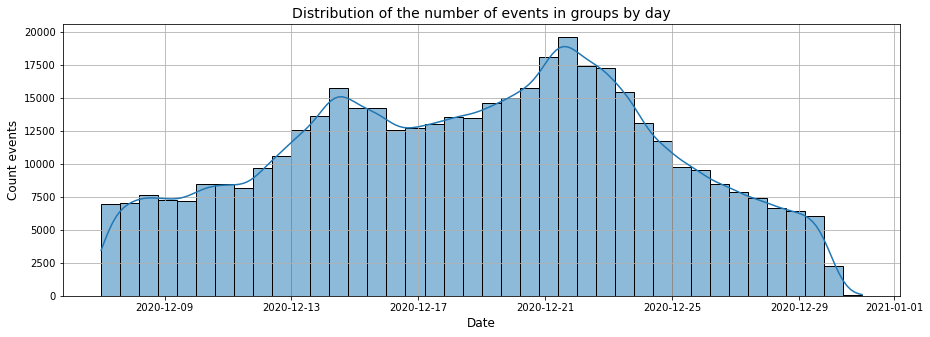

In [ ]:
# Build a graph of the distribution of the number of events in groups by day.
plt.figure(figsize=(15,5))
sns.histplot(data=events, x='event_dt', bins=40, kde=True, multiple='stack')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count events', fontsize=12)
plt.title ('Distribution of the number of events in groups by day', fontsize=14)
plt.grid()
plt.show()

**Вывод:**

Events, holidays, etc. - affect the two groups equally. This is just a change in the quality of users, but the relative conversion of group B to group A will not have an impact. But this must be taken into account when studying absolute data.

### Аудитория теста

In [ ]:
print('Tests:', participants['ab_test'].unique())


Tests: ['recommender_system_test' 'interface_eu_test']


In [ ]:
count = participants.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1').count()[0]
print(f"Count of users who participated in both tests: {count}")

Count of users who participated in both tests: 1602


In [ ]:
interface_eu_test_users = (
    participants
    .query('ab_test == "interface_eu_test"')['user_id']
)


recommender_system_test = (
    recommender_system_test
    .query('user_id not in @interface_eu_test_users')
)


In [ ]:
recommender_system_test

,user_id,group,ab_test,first_date,region
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU
5,4FF2998A348C484F,A,recommender_system_test,2020-12-20,EU
6,7473E0943673C09E,A,recommender_system_test,2020-12-16,EU
...,...,...,...,...,...
6345,A23B0A7FFF375BFF,B,recommender_system_test,2020-12-12,EU
6346,7C5C12FA1B5AB710,A,recommender_system_test,2020-12-21,EU
6347,91C3969B8A72B908,B,recommender_system_test,2020-12-09,EU
6348,E26F13A65CEAC6EA,A,recommender_system_test,2020-12-17,EU


<div class="alert alert-block alert-warning">📝
    

__Комментарий от тимлида №1__
    
Верное наблюдение.    
    
В данной ситуации, наиболее корректным решением будет проверить в какие именно группы теста interface_eu_test попали пользователи теста recommender_system_test. Ведь если они попали только в контрольную группу - это значит, что тест interface_eu_test никак на них не повлиял
</div>

In [ ]:
recommender_system_test_events = recommender_system_test.merge(
    events[['user_id', 'event_dt', 'event_name', 'details']],
    on='user_id',
    how='left')


In [ ]:
recommender_system_test_events.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test > 1').count()

ab_test    0
dtype: int64

In [ ]:
# Users participating in two groups
(
    recommender_system_test_events
    .groupby('user_id')
    .agg({'group': 'nunique'})
    .query('group > 1')
    .count()
)

group    0
dtype: int64

In [ ]:
# calculate the lifetime of the client.
recommender_system_test_events['lifetime'] = \
        (recommender_system_test_events['event_dt'] - recommender_system_test_events['first_date']).dt.days



In [ ]:
recommender_system_test_events = recommender_system_test_events.query('lifetime <= 14')
print('Count of participants:', recommender_system_test_events['user_id'].nunique())

Count of participants: 2594


In [ ]:
recommender_system_test_events

,user_id,group,ab_test,first_date,region,event_dt,event_name,details,lifetime
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,2020-12-07 14:43:27,purchase,99.99,0.0
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,2020-12-07 14:43:29,product_cart,NaN,0.0
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,2020-12-07 14:43:27,product_page,NaN,0.0
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,2020-12-07 14:43:27,login,NaN,0.0
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,2020-12-20 15:46:06,product_page,NaN,0.0
...,...,...,...,...,...,...,...,...,...
19676,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,2020-12-15 20:10:06,product_page,NaN,1.0
19677,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,2020-12-20 20:01:34,product_page,NaN,6.0
19678,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,2020-12-14 05:48:50,login,NaN,0.0
19679,80712ED4EA1B52A5,A,recommender_system_test,2020-12-14,EU,2020-12-15 20:10:03,login,NaN,1.0


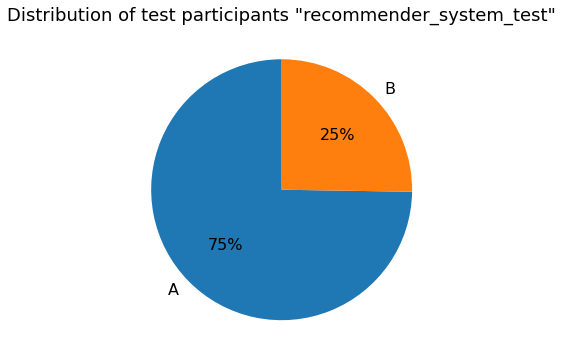

In [ ]:
unique_users = recommender_system_test_events.groupby('group')['user_id'].nunique()

labels = unique_users.index
sizes = unique_users.values
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.0f%%', startangle=90, textprops={'fontsize': 16})
ax.set_title('Distribution of test participants "recommender_system_test"', fontsize=18)
fig.set_size_inches(6, 6)
plt.show()

In [ ]:
unique_users

group
A    1939
B     655
Name: user_id, dtype: int64

**Things to consider:**
- Control the distribution of users between groups and tests
- Try to run tests outside of marketing campaigns
- The samples were large, in this case at least 6000 as stated
- Define metrics
- Write TK
- Define test duration
- Take into account other additional factors that may affect

**Conclusion:**

- In the samples, users are not evenly distributed, the ratio of A to I is 1 to 3
- Date of start and end of recruitment in the AV test corresponds to
- Events were recorded only until 12/30, 4 days were not recorded. Expected factor: New Year's festivities. You need to clarify the reasons for the failure
- Share of users matched
- The start of the marketing event had no effect
- The number of participants in the A / B test turned out to be 2 times less than in the TK
- 1600 users were included in 2 A/B tests

## EDA

### Number of events per user

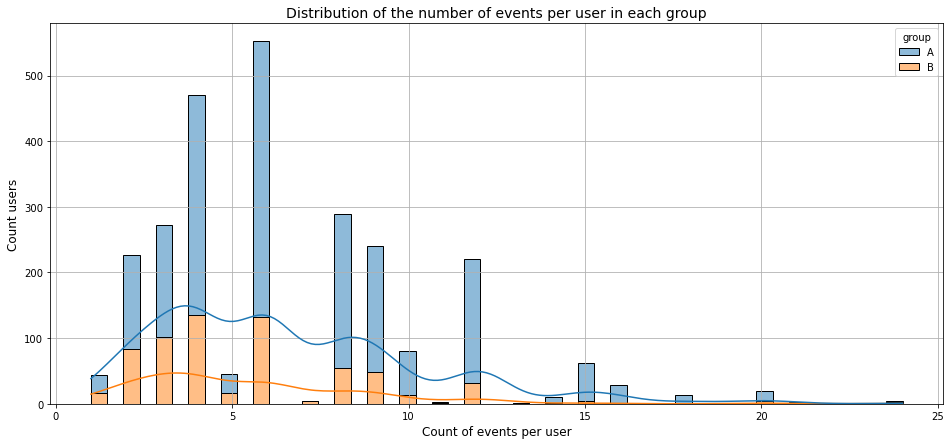

In [ ]:
users_per_day = recommender_system_test_events.groupby(['group', 'event_dt'])['user_id'].nunique().reset_index()

plt.figure(figsize=(16,7))
sns.histplot(data=recommender_system_test_events.groupby(['user_id', 'group']).size().reset_index(name='event_count'), x='event_count', hue='group', multiple='stack', kde=True, bins=50)
plt.xlabel('Count of events per user', fontsize=12)
plt.ylabel('Count users', fontsize=12)
plt.title('Distribution of the number of events per user in each group', fontsize=14)
plt.grid()
plt.show()

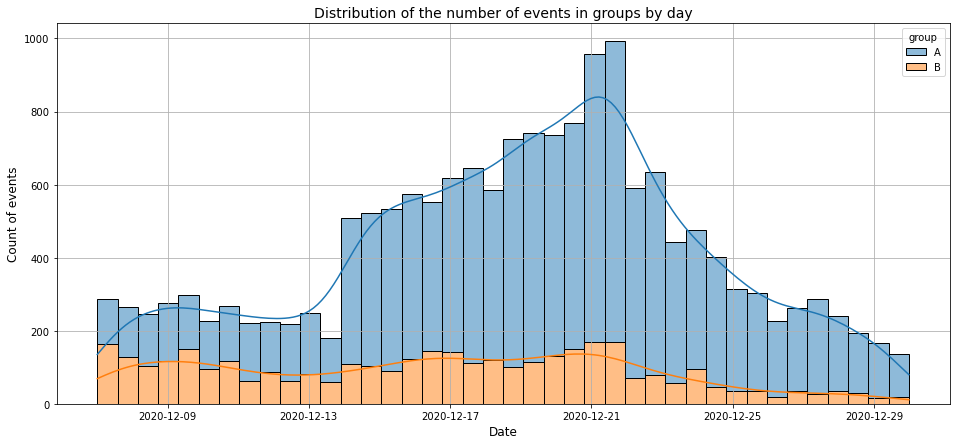

In [ ]:
# Build a graph of the distribution of the number of events in groups by day.
plt.figure(figsize=(16,7))
sns.histplot(data=recommender_system_test_events, x='event_dt', bins=40, hue='group', kde=True, multiple='stack')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Count of events', fontsize=12)
plt.title ('Distribution of the number of events in groups by day', fontsize=14)
plt.grid()
plt.show()

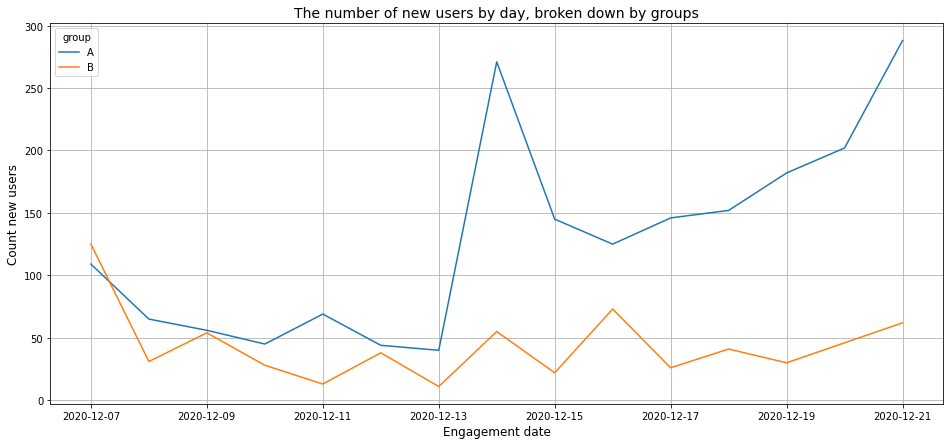

In [ ]:
users = recommender_system_test_events.groupby(['user_id', 'group'])['first_date'].min().reset_index()

new_users_by_day = users.groupby(['first_date', 'group'])['user_id'].count().reset_index()

plt.figure(figsize=(16,7))
sns.lineplot(data=new_users_by_day, x='first_date', y='user_id', hue='group')
plt.xlabel('Engagement date', fontsize=12)
        
plt.ylabel('Count new users', fontsize=12)
plt.title('The number of new users by day, broken down by groups', fontsize=14)
plt.grid()
plt.show()

**Summary:**

- Events are distributed with a significant difference, perhaps a large difference in groups affects
- There is a general growth dynamics from December 14 to December 21 and then a gradual decline
- from the 14th, a sharp jump in attracting new users, which influenced the jump in events in the same period

### Changing the conversion in the funnel in the samples at different stages

In [ ]:
unique_users

group
A    1939
B     655
Name: user_id, dtype: int64

In [ ]:
funnel_events = recommender_system_test_events.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique')\
                             .reindex(['login', 'product_page', 'product_cart', 'purchase'])\
                             .reset_index()
funnel_events['event_name'] = funnel_events['event_name'].replace({'product_page': 'Страница продукта', 'login': 'Логин',\
                                                'product_cart': 'Корзина','purchase': 'Покупка'})

funnel_events


group,event_name,A,B
0,Логин,1939,654
1,Страница продукта,1265,367
2,Корзина,589,184
3,Покупка,613,191


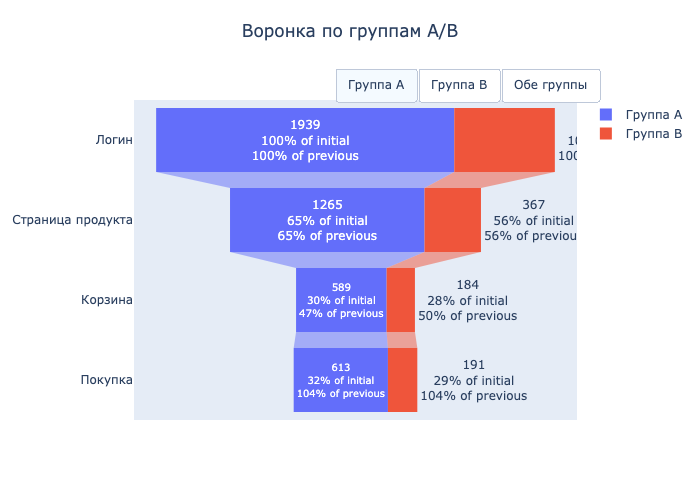

In [ ]:
# Create a funnel object for group A
fig = go.Figure(go.Funnel(
    name='Группа A',
    y = funnel_events['event_name'],
    x = funnel_events['A'],
    textposition = 'inside',
    textinfo = 'value+percent previous+percent initial'
))

# Add funnel object for group B
fig.add_trace(go.Funnel(
    name='Группа B',
    y = funnel_events['event_name'],
    x = funnel_events['B'],
    textposition = 'auto',
    textinfo = 'value+percent previous+percent initial'
))

# Set up the layout
fig.update_layout(
    title={
        'text': 'Воронка по группам А/В',
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    updatemenus=[go.layout.Updatemenu(
        buttons=list([
            dict(
                args=[{'visible': [True, False]}],
                label="Группа A",
                method="update"
            ),
            dict(
                args=[{'visible': [False, True]}],
                label="Группа B",
                method="update"
            ),
            dict(
                args=[{'visible': [True, True]}],
                label="Обе группы",
                method="update"
            )
        ]),
        type="buttons",
        direction="right",
        showactive=True,
        x=1.05,
        y=1.1
    )]
)

fig.update_traces(hovertemplate='%{y}: %{x:.0f} <br>Доля: %{percentInitial:.2%}')

fig.show()

**Summary:**
- The conversion in group A at all stages is higher than the conversion in group B
- Some users immediately buy without going to the cart

### Summary (What features of the data should be taken into account before proceeding with A/B testing?)

**Summary:**
- Events are distributed with a significant difference, perhaps a large difference in groups affects
- The general dynamics of growth is traced from December 13 to December 21 and then a gradual decline
- The conversion in group A at all stages is higher than the conversion in group B
- Do some users immediately buy without going to the cart?

**Things to consider:**
- Control the distribution of users between groups and tests
- Try to run tests outside of marketing campaigns
- The samples were large, in this case at least 6000 as stated
- Define metrics
- Write TK
- Define test duration
- Take into account other additional factors that may affect
- Make sure all data is accurate
- Do not start the test on December 31 at 10 pm

## A/B testing results

**Summary:**
- Events are distributed with a significant difference, perhaps a large difference in groups affects
- The general dynamics of growth is traced from December 13 to December 21 and then a gradual decline
- The conversion in group A at all stages is higher than the conversion in group B
- Do some users immediately buy without going to the cart?
- Users in test groups were distributed in violation of the terms of reference.
- Groups are unevenly divided, group A has more users.
- The number of users for the test is very small
- Users in group A commit more events than users in group B.
- Since the 14th, a sharp jump in attracting new users, which influenced the jump in events in the same period

## Statistical difference of fractions (z-criterion)

**Hypotheses:**
- H0: Group A and B conversion are equal.
- H1: Conversion groups A and B are not equal

In [ ]:

def z_test(first_group, second_group, alpha_value):
    alpha = alpha_value / 3 
    event_name = funnel_events['event_name']
    
    for i, event in enumerate(event_name[1:], start=1):
        n1, n2 = first_group[0], second_group[0]  
        x1, x2 = first_group[i], second_group[i]  
        
        
        
        p1, p2 = x1/n1, x2/n2  
        
        print(x1, x2, n1, n2)
        p_combined = (x1 + x2) / (n1 + n2)  
        
        z_value = (p1 - p2) / np.sqrt(p_combined * (1 - p_combined) * (1/n1 + 1/n2))
        
        p_value = 2 * (1 - norm.cdf(abs(z_value)))
        
        print(f"Событие: {event}")
        print(f"p-value = {p_value:.3f}")
        if p_value < alpha:
            print("Отвергаем нулевую гипотезу")
        else:
            print("Не получилось отвергнуть нулевую гипотезу")
        print("")

In [ ]:
z_test(funnel_events['A'], funnel_events['B'], 0.05)


1265 367 1939 654
Событие: Страница продукта
p-value = 0.000
Отвергаем нулевую гипотезу

589 184 1939 654
Событие: Корзина
p-value = 0.278
Не получилось отвергнуть нулевую гипотезу

613 191 1939 654
Событие: Покупка
p-value = 0.249
Не получилось отвергнуть нулевую гипотезу



**Sammury:**

- statistical test showed a significant difference in the Product Page event
- for the funnel steps Cart and Purchase, the statistical test showed no significant difference

## Summary

**Violations:**
- Users were unevenly distributed between groups:
     - A 1939
     -B655
- Users were simultaneously in 2 tests (1602 users)
- The test took place almost in parallel with a big marketing event
- The test ended ahead of schedule (30.12) - 4 days are missing
- The selection of users from different regions did not meet the requirements specification

As a result of all violations, the sample remained insignificant and with a large preponderance of group A, all these violations can lead to incorrect conclusion of the test results.


**Data exploration:**
- In group A, the number of events per user is higher
- Events by day are distributed differently
- A has a higher conversion rate than B


**Statistical analysis**

- statistical test showed a significant difference in the Product Page event
- for the funnel steps Cart and Purchase, the statistical test showed no significant difference


Testing was not carried out in accordance with the established TOR and numerous violations, at this stage it is not worth making decisions based on the results obtained. It is necessary to re-test, in accordance with the terms of reference.